In [1]:
print("hello")

hello


In [3]:
! pip install mip
# Mixed Integer Linear Programming
from mip import *

     |████████████████████████████████| 48.0MB 93kB/s 


MODULE 1

In [4]:
def module1(GPh,disutility,t,E,SD,IE,P1,MinC,MaxC,SP,RQ,beta,Lmax):
    """ 
    Entrées : Différents paramètres des maisons, leurs machines, stockages et énergies renouvelables.
    Sorties : Le cout sur toute la durée de l'expérience, sans aucun trading.
              A chaque pas de temps, offre/demande de la maison en enrgie sur la Microgrid 
    """
    m = Model(sense=MINIMIZE,solver_name=CBC)
    
    # Consommation d'énergie de la grille forunisseur par la maison.
    # Contrainte 15 : GE < Lmax 
    GE = [ m.add_var(name='GE'+str(i),ub=Lmax,lb=0) for i in range(1,25)]
    
    # Heures d'activation de la machine dans la maison
    S = [ m.add_var(name='S'+str(i),var_type=BINARY) for i in range(1,25)]

    # Heures de charge de la batterie dans la maison
    IC = [ m.add_var(name='IC'+str(i),var_type=BINARY) for i in range(1,25)]
    
    # Consommation d'énerge de la batterie à chaque heure
    BE = [ m.add_var(name='BE'+str(i)) for i in range(1,25)]
    
    # Consomation d'énergie renouvelable à chaque heure
    # Contrainte 9: RE < RQ, on ne consomme pas plus que l'on ne produit
    RE = [ m.add_var(name='RE'+str(i),ub=RQ[i-1]) for i in range(1,25) ]
    
    # Niveau decharge de la batterie à chaque heure
    # Contraintes 6 et 7 : MinC < SE < MaxC
    SE = [ m.add_var(name='SE'+str(i),ub=MaxC,lb=MinC) for i in range(1,25)]
    
    # Heure de fin de fonctionnement de la machine
    # Contrainte 12 : Tau < Beta, La machine doit avoir terminé avant telle heure
    tau = m.add_var(name='Tau',ub=beta)
    
    # Equilibre énergétique sans échange sur microgrid
    # Contrainte 3 : Consommation = Production
    # Consommation = Machine_active * puissance + charge de la batterie
    # Production : Energie de la grille, DU stockage et renouvelable 
    for h in range(0,24):
        m+= (S[h]*P1 + IC[h]*SP == GE[h] + BE[h] + RE[h]) 
    
    # Niveau d'énergie initial dans le stockage
    # Contrainte 4 : 
    # Niveau = Initial * coeff_perte + Charge? * Valeur de charge * efficatité - Energie consommée 
    m+= SE[0] == IE*SD + IC[0]*SP*E-BE[0]
    
    # Niveau d'énergie dans le stockage à un moment h
    # Contrainte 5 : 
    # Niveau = Niveau précédent * coeff_perte + Charge? * Valeur de charge * efficatité - Energie consommée 
    for h in range(1,24):
        m+= SE[h] == SE[h-1]*SD  + IC[h]*SP*E-BE[h]
    
    # La machine doit faire ses t heures de travails
    # Contrainte 8 : Somme des activations = durée d'activation de la machine
    m+= xsum(S[h] for h in range(24)) == t
    
    # La machine doit finir à la date où elle finit
    #Contrainte 11 : dernière activation <= tau
    for h in range(24):
        m+= (h+1)*S[h] <= tau
    
    # End constraint
    
    # Fonction objectif
    m.objective = xsum(GPh[h] * GE[h] for h in range(24)) + disutility*tau

    # Résolution
    m.max_gap = 0.01
    status = m.optimize(max_seconds=30)
    """
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(m.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        print('solution:')
        for v in m.vars:
        if abs(v.x) > 1e-6: # only printing non-zeros
           print('{} : {}'.format(v.name, v.x))
    if status == OptimizationStatus.INFEASIBLE:
        print("Infeasible")
    """
    # Se référe à la contrainte 16
    # DSk reprend la demande ou l'offre de la maisn à qhaue pas de temps, en ne considérant
    # la batterie et l'énergie renouvelable.
    # Positif si il y a un besoin
    # Negatif si il y a un surplus
    dsk = []
    
    # Récupération des valeurs
    for i in range(24):
        dsk.append(m.vars['S'+str(i+1)].x*P1 + m.vars['IC'+str(i+1)].x*SP - RQ[i]-
                   m.vars['SE'+str(i+1)].x-m.vars['BE'+str(i+1)].x+MinC)
    return m.objective_bound,dsk


MODULE 2

In [6]:

def module2(GPh,disutility,t,E,SD,IE,P1,MinC,MaxC,SP,RQ,beta,Lmax,CK_noTrade_1,ME_1
            ,disutility2,t2,E2,SD2,IE2,P2,MinC2,MaxC2,SP2,RQ2,beta2,CK_noTrade_2,ME_2):
  
    """
    Entrées : Les paramètres des différentes maisons comme dans le module 1, mais en plus
              leur valeurs de DSK qui ont ici le nom de ME, si l'on est à la première passe 
              de l'itération dans ECO-TRADE. Sinon c'est le ME de sortie du module 3
    Sorties : Le prix de l'énergie sur la MicroGrid 
    """
 
    m = Model(sense=MINIMIZE,solver_name=CBC)
    
    # Prix de l'énergie sur la microgrid aux différentes heures
    # contraintes 22 et 23 : Le prix doit être positif et ne pas excéder le prix
    # sur la grille du fournisseur
    MP = [ m.add_var(name='MP'+str(i),ub=GPh[i-1],lb=0) for i in range(1,25)]
    
    # Maison 1
    # Consommation d'énergie de la grille forunisseur par la maison.
    # Contrainte 15 : GE < Lmax 
    GE_1 = [ m.add_var(name='GE_1'+str(i),ub=Lmax,lb=0) for i in range(1,25)]
    
    # Heures d'activation de la machine dans la maison
    S_1 = [ m.add_var(name='S_1'+str(i),var_type=BINARY) for i in range(1,25)]

    # Heures de charge de la batterie dans la maison
    IC_1 = [ m.add_var(name='IC_1'+str(i),var_type=BINARY) for i in range(1,25)]

    # Consommation d'énerge de la batterie à chaque heure
    BE_1 = [ m.add_var(name='BE_1'+str(i)) for i in range(1,25)]

    # Consomation d'énergie renouvelable à chaque heure
    # Contrainte 9: RE < RQ, on ne consomme pas plus que l'on ne produit
    RE_1 = [ m.add_var(name='RE_1'+str(i),ub=RQ[i-1]) for i in range(1,25) ]
    
    # Niveau decharge de la batterie à chaque heure
    # Contraintes 6 et 7 : MinC < SE < MaxC
    SE_1 = [ m.add_var(name='SE_1'+str(i),ub=MaxC,lb=MinC) for i in range(1,25)]
    
    # Heure de fin de fonctionnement de la machine
    # Contrainte 12 : Tau < Beta, La machine doit avoir terminé avant telle heure
    tau_1 = m.add_var(name='Tau_1',ub=beta)
    
    # Maison 2
    # Consommation d'énergie de la grille forunisseur par la maison.
    # Contrainte 15 : GE < Lmax 
    GE_2 = [ m.add_var(name='GE_2'+str(i),ub=Lmax,lb=0) for i in range(1,25)]
    
    # Heures d'activation de la machine dans la maison
    S_2 = [ m.add_var(name='S_2'+str(i),var_type=BINARY) for i in range(1,25)]
    
    # Heures de charge de la batterie dans la maison
    IC_2 = [ m.add_var(name='IC_2'+str(i),var_type=BINARY) for i in range(1,25)]

    # Consommation d'énerge de la batterie à chaque heure
    BE_2 = [ m.add_var(name='BE_2'+str(i)) for i in range(1,25)]
  
    # Consomation d'énergie renouvelable à chaque heure
    # Contrainte 9: RE < RQ, on ne consomme pas plus que l'on ne produit
    RE_2 = [ m.add_var(name='RE_2'+str(i),ub=RQ2[i-1]) for i in range(1,25) ]

    # Niveau decharge de la batterie à chaque heure
    # Contraintes 6 et 7 : MinC < SE < MaxC
    SE_2 = [ m.add_var(name='SE_2'+str(i),ub=MaxC2,lb=MinC2) for i in range(1,25)]
    
    # Heure de fin de fonctionnement de la machine
    # Contrainte 12 : Tau < Beta, La machine doit avoir terminé avant telle heure
    tau_2 = m.add_var(name='Tau_2',ub=beta2)

    # Contraintes
    
    # Niveau d'énergie dans le stockage
    # Contrainte 4 et 5: 
    # Niveau = Initial * coeff_perte + Charge? * Valeur de charge * efficatité - Energie consommée 
    m+= SE_1[0] == IE*SD + IC_1[0]*SP*E-BE_1[0]
    m+= SE_2[0] == IE2*SD2 + IC_2[0]*SP2*E2-BE_2[0]
    
    # Niveau = Niveau précédent * coeff_perte + Charge? * Valeur de charge * efficatité - Energie consommée 
    for h in range(1,24):
        m+= SE_1[h] == SE_1[h-1]*SD  + IC_1[h]*SP*E-BE_1[h]
        m+= SE_2[h] == SE_2[h-1]*SD2  + IC_2[h]*SP2*E2-BE_2[h]
    
    # La machine doit faire ses t heures de travails
    # Contrainte 8 : Somme des activations = durée d'activation de la machine
    m+= xsum(S_1[h] for h in range(24)) == t
    m+= xsum(S_2[h] for h in range(24)) == t2

    # La machine doit finir à la date où elle finit
    # Contrainte 11 : dernière activation <= tau
    for h in range(24):
        m+= (h+1)*S_1[h] <= tau_1
        m+= (h+1)*S_2[h] <= tau_2
        
    # Equilibre énergétique avec la microgrid
    # Contrainte 21
    for h in range(0,24):
            m+= (S_1[h]*P1 + IC_1[h]*SP <= GE_1[h] + BE_1[h] + RE_1[h] + ME_1[h]) 
            m+= (S_2[h]*P2 + IC_2[h]*SP2 <= GE_2[h] + BE_2[h] + RE_2[h] + ME_2[h]) 
    
    # Equilibre de Pareto : l'échange doit être profitable pour tous
    #Constrain 24
    m+= xsum( GPh[h] * GE_1[h] + MP[h] * ME_1[h]  for h in range(24)) + disutility*tau_1 <= CK_noTrade_1
    m+= xsum(GPh[h] * GE_2[h]+ MP[h]*ME_2[h] for h in range(24)) + disutility2*tau_2 <= CK_noTrade_2
    
    m.objective = xsum(GPh[h] * GE_1[h] + GPh[h] * GE_2[h] for h in range(24)) + disutility*tau_1 + disutility2*tau_2
    m.max_gap = 0.01
    status = m.optimize(max_seconds=30)
    """
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(m.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        print('solution:')
        for v in m.vars:
        if abs(v.x) > 1e-6: # only printing non-zeros
           print('{} : {}'.format(v.name, v.x))
    if status == OptimizationStatus.INFEASIBLE:
                   print("Infeasible")
    """
    MP_out = [] # prix de l'énergie sur la microgrid à la résolution
    for i in range(24):
        MP_out.append(m.vars['MP'+str(i+1)].x)
    return MP_out

MODULE 3

In [7]:
import math
def module3(GPh,disutility1,t1,E1,SD1,IE1,P1,MinC1,MaxC1,SP1,RQ1,beta1,Lmax,CK_noTrade_1,MP
            ,disutility2,t2,E2,SD2,IE2,P2,MinC2,MaxC2,SP2,RQ2,beta2,CK_noTrade_2):
    m = Model(sense=MINIMIZE,solver_name=CBC)

    # Beaucoup de variables sont similaires aux modules 1 et 2 

    # Les nouvelles : 
    # Mp est fixée par le module 2 précédent
    # on cherhce maintenant à déterminer l'échange d'énergie sur la microgrid
    
    
    GE_1 = [ m.add_var(name='GE_1'+str(i),ub=Lmax,lb=0) for i in range(1,25)]
    S_1 = [ m.add_var(name='S_1'+str(i),var_type=BINARY) for i in range(1,25)]
    IC_1 = [ m.add_var(name='IC_1'+str(i),var_type=BINARY) for i in range(1,25)]
    BE_1 = [ m.add_var(name='BE_1'+str(i)) for i in range(1,25)]
    RE_1 = [ m.add_var(name='RE_1'+str(i),ub=RQ1[i-1]) for i in range(1,25) ]
    SE_1 = [ m.add_var(name='SE_1'+str(i),ub=MaxC1,lb=MinC1) for i in range(1,25)]
    ME_1 = [ m.add_var(name='ME1'+str(i),lb=-math.inf,ub=math.inf) for i in range(1,25)]
    tau_1 = m.add_var(name='Tau_1',ub=beta1)
    #Demande ou surplus d'énergie sur la microgrid
    MQ_1 = [ m.add_var(name='MQ1'+str(i),lb=-math.inf,ub=math.inf) for i in range(1,25)]
    
    GE_2 = [ m.add_var(name='GE_2'+str(i),ub=Lmax,lb=0) for i in range(1,25)]
    S_2 = [ m.add_var(name='S_2'+str(i),var_type=BINARY) for i in range(1,25)]
    IC_2 = [ m.add_var(name='IC_2'+str(i),var_type=BINARY) for i in range(1,25)]
    BE_2 = [ m.add_var(name='BE_2'+str(i)) for i in range(1,25)]
    RE_2 = [ m.add_var(name='RE_2'+str(i),ub=RQ2[i-1]) for i in range(1,25) ]
    SE_2 = [ m.add_var(name='SE_2'+str(i),ub=MaxC2,lb=MinC2) for i in range(1,25)]
    ME_2 = [ m.add_var(name='ME2'+str(i),lb=-math.inf,ub=math.inf) for i in range(1,25)]
    tau_2 = m.add_var(name='Tau_2',ub=beta2)
    #Demande ou surplus d'énergie sur la microgrid
    MQ_2 = [ m.add_var(name='MQ2'+str(i),lb=-math.inf,ub=math.inf) for i in range(1,25)]
    
    
    #Contrainte 4&5
    m+= SE_1[0] == IE1*SD1 + IC_1[0]*SP1*E1-BE_1[0]
    m+= SE_2[0] == IE2*SD2 + IC_2[0]*SP2*E2-BE_1[0]
    
    for h in range(1,24):
        m+= SE_1[h] == SE_1[h-1]*SD1 + IC_1[h]*SP1*E1-BE_1[h]
        m+= SE_2[h] == SE_2[h-1]*SD2  + IC_2[h]*SP2*E2-BE_2[h]
    #Contrainte 8
    m+= xsum(S_1[h] for h in range(24)) == t1
    m+= xsum(S_2[h] for h in range(24)) == t2
    #Contrainte 11
    for h in range(24):
        m+= (h+1)*S_1[h] <= tau_1
        m+= (h+1)*S_2[h] <= tau_2
        
    #Constrain 25
    for h in range(0,24):
            m+= (S_1[h]*P1 + IC_1[h]*SP1 == GE_1[h] + BE_1[h] + RE_1[h] + ME_1[h]) 
            m+= (S_2[h]*P2 + IC_2[h]*SP2 == GE_2[h] + BE_2[h] + RE_2[h] + ME_2[h]) 
    #Constrain 24
    m+= xsum(GPh[h] * GE_1[h] + MP[h] * ME_1[h]  for h in range(24)) + disutility1*tau_1 <= CK_noTrade_1
    m+= xsum(GPh[h] * GE_2[h]+ MP[h]*ME_2[h] for h in range(24)) + disutility2*tau_2 <= CK_noTrade_2
    
    #Constrain 26
    for h in range(24):
        m+= ME_1[h]  + ME_2[h]  == 0

    #Constrain 27
    for h in range(24):
        m+= MQ_1[h] == (S_1[h]*P1+IC_1[h]*SP1 - GE_1[h] - RQ1[h]-SE_1[h] - BE_1[h]) + MinC1
        m+= MQ_2[h] == (S_2[h]*P2+IC_2[h]*SP2 - GE_2[h] - RQ2[h]-SE_2[h] - BE_2[h]) + MinC2
     

    #Constrain 28
    for h in range(24):
        m+=ME_1[h] >= MQ_1[h]
        m+=ME_2[h] >= MQ_2[h]
   
    m.objective = xsum(GPh[h] * GE_1[h] + GPh[h] * GE_2[h] for h in range(24)) + disutility1*tau_1 + disutility2*tau_2
    
    m.max_gap = 0.01
    status = m.optimize(max_seconds=30)
    """
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(m.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    print('solution:')
    for v in m.vars:
       if abs(v.x) > 1e-6: # only printing non-zeros
          print('{} : {}'.format(v.name, v.x))
    if status == OptimizationStatus.INFEASIBLE:
                   print("Infeasible")
    """
    ME_1_out = []
    ME_2_out = []
    GE_1_out = []
    GE_2_out = []
    SE_1_out = []
    SE_2_out = []
    S_1_out = []
    S_2_out = []
    for i in range(24):
        ME_1_out.append(m.vars['ME1'+str(i+1)].x)
        ME_2_out.append(m.vars['ME2'+str(i+1)].x)
        GE_1_out.append(m.vars['GE_1'+str(i+1)].x)
        GE_2_out.append(m.vars['GE_2'+str(i+1)].x)
        SE_1_out.append(m.vars['SE_1'+str(i+1)].x)
        SE_2_out.append(m.vars['SE_2'+str(i+1)].x)
        S_1_out.append(m.vars['S_1'+str(i+1)].x)
        S_2_out.append(m.vars['S_2'+str(i+1)].x)
    return m.objective_bound,[ME_1_out,ME_2_out],[GE_1_out,GE_2_out],[SE_1_out,SE_2_out],[S_1_out,S_2_out]
    

In [8]:
# ECO-TRADE Algorithm
GPh = [0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.15,0.15,0.15,0.15,0.15,0.17,0.17,0.17,0.17,0.15,0.15,0.15,0.13,0.13,0.13,0.13]
Lmax = 6000
#initialisation maison1
disutility1 = 0.1 # coefficient mitigant le cout du délai d'une machine
t1 = 3  # temps d'activation de la machine 1 nécessaire pour réaliser sa tâche
E1 = 0.1  # Efficacité du stockage 
IE1 = 2.6 # Energie stockée initialement
SD1 = 1 # Coefficient de perte du stockage
P1 = 1800  # Puissance de la machine
MinC1 = 2.6 # min stockage
MaxC1 = 6.4 # max stockage
SP1 = 1 # Charge du stockage se fait de SP en SP
RQ1 = [1 for _ in range(24)]  # Energie renouvelable produite
beta1 = 12 # date final piur l'execution d'une tâche

# initialisation maison2
disutility2 = 0.2 # coefficient mitigant le cout du délai d'une machine
t2 = 10   # temps d'activation de la machine 1 nécessaire pour réaliser sa tâche
E2 = 0.1 # Efficacité du stockage 
IE2 = 0 # Energie stockée initialement
SD2 = 1 # Coefficient de perte du stockage
P2= 800  # Puissance de la machine
MinC2 = 0 # min stockage
MaxC2 = 10# max stockage
SP2 = 0.1  # Charge du stockage se fait de SP en SP
RQ2 = [0.1 for _ in range(24)]  # Energie renouvelable produite
beta2 = 23 # date final piur l'execution d'une tâche


# paramètres et variable pour ECO-TRADE
appliance = None
epsilon_count, epsilon_max, Cpre = 0, 3, 0
Ccur, epsilon_cur, epsilon = 1, 0, 0.7

#initialisation des CK_not_Trade : Module 1 pour chaque maison
CK_NoTrade_1,DSK1 = module1(GPh,disutility1,t1,E1,SD1,IE1,P1,MinC1,MaxC1,SP1,RQ1,beta1,Lmax)
CK_NoTrade_2,DSK2 = module1(GPh,disutility1,t2,E2,SD2,IE2,P2,MinC2,MaxC2,SP2,RQ2,beta2,Lmax)
Cpre = CK_NoTrade_1 + CK_NoTrade_2

prix = 0
echange = None
fin = None
batterie = None
print("Cost at initialization :", Cpre)
i = 1
# Boucle
while epsilon_count <= epsilon_max:
    print("*****************************"+str(i)+"**************")
    i+=1
    
    prix = module2(GPh,disutility1,t1,E1,SD1,IE1,P1,MinC1,MaxC1,SP1,RQ1,beta1,Lmax,CK_NoTrade_1,DSK1
            ,disutility1,t2,E2,SD2,IE2,P2,MinC2,MaxC2,SP2,RQ2,beta2,CK_NoTrade_2,DSK2)
    
    Ccur, fin,echange,batterie,appliance = module3(GPh,disutility1,t1,E1,SD1,IE1,P1,MinC1,MaxC1,SP1,RQ1,beta1,Lmax,CK_NoTrade_1,prix
            ,disutility1,t2,E2,SD2,IE2,P2,MinC2,MaxC2,SP2,RQ2,beta2,CK_NoTrade_2)
    
    epsilon_cur = abs((Cpre - Ccur)/Cpre)

    if epsilon_cur <= epsilon:
        epsilon_count += 1
    else:
        epsilon_count = 0
    Cpre = Ccur
# final solution :
print("Solution :", fin)



End constraint
End constraint
Cost at initialization : 1743.8994007282472
*****************************1**************
end
End constraint
end
*****************************2**************
end
End constraint
end
*****************************3**************
end
End constraint
end
*****************************4**************
end
End constraint
end
Solution : [[1801.0, 0.09999999999999999, 1798.8999999999999, -1.0, -1.0, -1.0, -799.9000000000001, -799.9, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -799.7700000000001, -799.9000000000001, -0.9999999999999113, 0.0], [-1801.0, -0.09999999999999999, -1798.8999999999999, 1.0, 1.0, 1.0, 799.9000000000001, 799.9, 0.0, 0.0, -2.2204460492503132e-17, -2.2204460492503132e-17, -2.2204460492503132e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 799.7700000000001, 799.9000000000001, 0.9999999999999113, 0.0]]


'\nprint("Cost at initialization :", Cpre)\nwhile epsilon_count <= epsilon_max:\n    module2()\n    Ccur, x = module3()\n\n    epsilon_cur = abs((Cpre - Ccur)/Cpre)\n    if epsilon_cur <= epsilon:\n        epsilon_count += 1\n    else:\n        epsilon_count = 0\n    Cpre = Ccur\n\n# final solution :\nprint("Solution :", x)\n'

In [9]:
#on affiche prix grille, prix microgrille
#Tire grille, tire microgrille
#stockage de chaque batterie + prod nrj renouvlable
prix_micro = prix
prix_grille = GPh
echange_micro_1 = fin[0]
echange_micro_2 = fin[1]
import_grille_1 = echange[0]
import_grille_2 = echange[1]
storage_batterie_1 = batterie[0]
storage_batterie_2 = batterie[1]
nrj_renouvlable_1 = RQ1
nrj_renouvlable_2 = RQ2
appliance_1 = appliance[0]
appliance_2 = appliance[1]


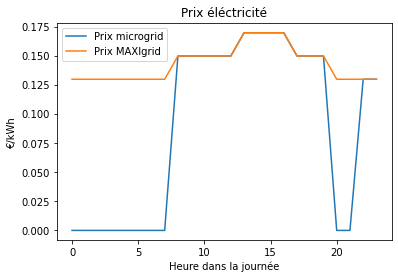

In [10]:
import matplotlib.pyplot as plt

plt.plot([x for x in range(len(prix_micro))],prix_micro,label='Prix microgrid')
plt.plot([x for x in range(len(prix_grille))],prix_grille,label='Prix MAXIgrid')
plt.xlabel("Heure dans la journée")
plt.ylabel("€/kWh")
plt.title("Prix éléctricité")

plt.legend()
plt.show()

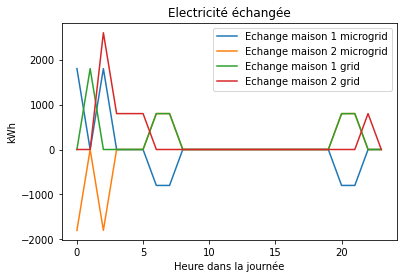

In [11]:

plt.plot([x for x in range(len(echange_micro_1))],echange_micro_1,label='Echange maison 1 microgrid')
plt.plot([x for x in range(len(echange_micro_2))],echange_micro_2,label='Echange maison 2 microgrid')
plt.plot([x for x in range(len(import_grille_1))],import_grille_1,label='Echange maison 1 grid')
plt.plot([x for x in range(len(import_grille_2))],import_grille_2,label='Echange maison 2 grid')
plt.xlabel("Heure dans la journée")
plt.ylabel("kWh")
plt.title("Electricité échangée")
plt.legend()
plt.show()

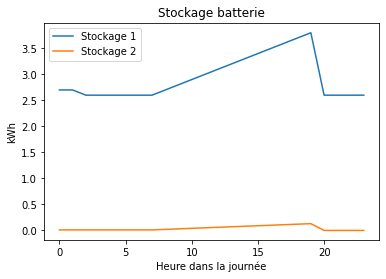

In [12]:
plt.plot([x for x in range(len(storage_batterie_1))],storage_batterie_1,label='Stockage 1')
plt.plot([x for x in range(len(storage_batterie_2))],storage_batterie_2,label='Stockage 2')
plt.xlabel("Heure dans la journée")
plt.ylabel("kWh")
plt.title("Stockage batterie")
plt.legend()
plt.show()

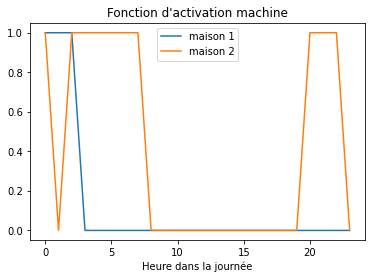

In [13]:
plt.plot([x for x in range(len(appliance_1))],appliance_1,label="maison 1")
plt.plot([x for x in range(len(appliance_2))],appliance_2,label="maison 2")
plt.xlabel("Heure dans la journée")
plt.title("Fonction d'activation machine")
plt.legend()
plt.show()